In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv(r'./breast cancer.csv')

In [6]:
df.diagnosis.unique()

array(['M', 'B'], dtype=object)

In [7]:
df['diagnosis'].value_counts()

diagnosis
B    357
M    212
Name: count, dtype: int64

## 清理并准备数据

In [8]:
df.drop('id',axis=1,inplace=True)
df.drop('Unnamed: 32',axis=1,inplace=True)

In [9]:
df['diagnosis'] = df['diagnosis'].map({'M':1,'B':0})#1为恶性0为良性
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [11]:
# 删除所有worst列
cols = ['radius_worst', 
        'texture_worst', 
        'perimeter_worst', 
        'area_worst', 
        'smoothness_worst', 
        'compactness_worst', 
        'concavity_worst',
        'concave points_worst', 
        'symmetry_worst', 
        'fractal_dimension_worst']
df = df.drop(cols, axis=1)

# 删除与perimeter和area相关的列
cols = ['perimeter_mean',
        'perimeter_se', 
        'area_mean', 
        'area_se']
df = df.drop(cols, axis=1)

# 删除与concavity和concave points相关的列
cols = ['concavity_mean',
        'concavity_se', 
        'concave points_mean', 
        'concave points_se']
df = df.drop(cols, axis=1)

# 确认剩下的列有哪些，后续要作为输入量
df.columns

Index(['diagnosis', 'radius_mean', 'texture_mean', 'smoothness_mean',
       'compactness_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'smoothness_se', 'compactness_se',
       'symmetry_se', 'fractal_dimension_se'],
      dtype='object')

## 构建模型

In [12]:
X=df.drop(['diagnosis'],axis=1)#除是否为恶性的其它列都是输入
y = df['diagnosis']#阳/阴性是输出标签

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=40)#划分训练集和测试集，random_state=40确保可重复性

### 特征缩放

In [15]:
from sklearn.preprocessing import StandardScaler
ss=StandardScaler()
#对数据集的特征进行标准化（正态分布）
X_train=ss.fit_transform(X_train)
X_test=ss.fit_transform(X_test)

### 多种回归模型

#### K Nearest Neighbor (K NN) K临近
#### Support Vector Machine   支持向量机
#### Naive Bayes   朴素贝叶斯

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve, classification_report

In [17]:
# 定义模型和扩展的超参数网格
models = [
    ('KNN', KNeighborsClassifier(), {
        'n_neighbors': [3, 5, 7, 9, 11, 15],
        'weights': ['uniform', 'distance'],
        'p': [1, 2]
    }),
    ('NB', GaussianNB(), {
        'var_smoothing': np.logspace(-10, -8, num=20)
    }),
    ('SVM', SVC(probability=True), {
        'C': [0.01, 0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
        'degree': [2, 3]
    })
]

In [18]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, learning_curve
import os

In [19]:
# 交叉验证和模型评估
results = []
names = []
kfold = KFold(n_splits=10, random_state=40, shuffle=True)
best_models = {}

for name, model, params in models:
    grid_search = GridSearchCV(model, params, cv=kfold, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    cv_results = cross_val_score(best_model, X_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    best_models[name] = best_model
    print(f"{name} Cross-Validation Results:")
    print(f"Mean Accuracy: {cv_results.mean():.4f} (±{cv_results.std():.4f})")
    print(f"Best Parameters: {grid_search.best_params_}\n")

KNN Cross-Validation Results:
Mean Accuracy: 0.9297 (±0.0349)
Best Parameters: {'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}

NB Cross-Validation Results:
Mean Accuracy: 0.8997 (±0.0641)
Best Parameters: {'var_smoothing': 1e-10}

SVM Cross-Validation Results:
Mean Accuracy: 0.9197 (±0.0472)
Best Parameters: {'C': 10, 'degree': 2, 'gamma': 0.001, 'kernel': 'rbf'}



In [22]:
# 训练并评估所有模型
for name, model in best_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # 计算分类报告
    report = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).T
    report_df = report_df.round(2)
    print(f"\n{name} Performance Metrics:")
    print(report_df.to_string())

    # 计算测试集准确率
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f"\n{name} Test Accuracy: {test_accuracy:.4f}")


KNN Performance Metrics:
              precision  recall  f1-score  support
0                  0.96    0.97      0.97   115.00
1                  0.94    0.91      0.93    56.00
accuracy           0.95    0.95      0.95     0.95
macro avg          0.95    0.94      0.95   171.00
weighted avg       0.95    0.95      0.95   171.00

KNN Test Accuracy: 0.9532

NB Performance Metrics:
              precision  recall  f1-score  support
0                  0.94    0.96      0.95   115.00
1                  0.91    0.88      0.89    56.00
accuracy           0.93    0.93      0.93     0.93
macro avg          0.92    0.92      0.92   171.00
weighted avg       0.93    0.93      0.93   171.00

NB Test Accuracy: 0.9298

SVM Performance Metrics:
              precision  recall  f1-score  support
0                  0.95    0.97      0.96   115.00
1                  0.94    0.89      0.92    56.00
accuracy           0.95    0.95      0.95     0.95
macro avg          0.95    0.93      0.94   171.00
wei

In [23]:
# 训练并评估所有模型
for name, model in best_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # 混淆矩阵
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
    print(f"\n{name} Confusion Matrix:")
    print(cm_df.to_string())


KNN Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0          112            3
Actual 1            5           51

NB Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0          110            5
Actual 1            7           49

SVM Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0          112            3
Actual 1            6           50


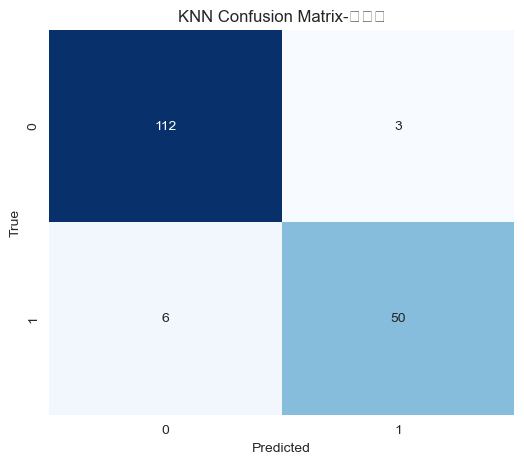

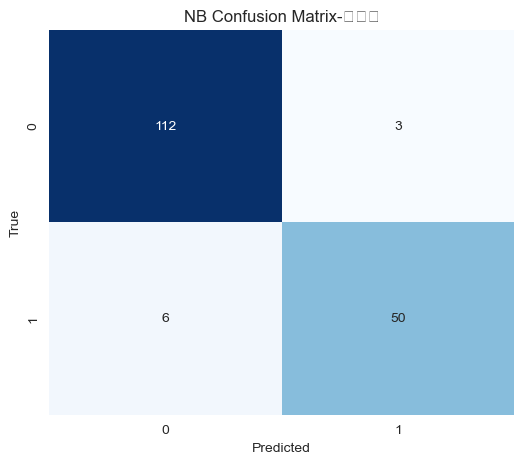

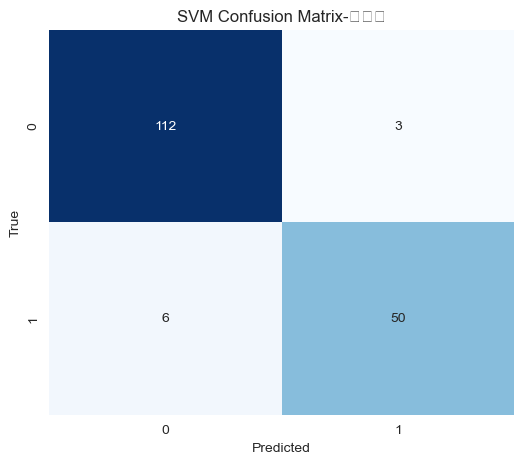

In [24]:
# 训练并评估所有模型
for name, model in best_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    # 混淆矩阵热图
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.title(f'{name} Confusion Matrix-任展绘')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    os.makedirs(f'picture/{name}', exist_ok=True)
    plt.savefig(f'picture/{name}/confusion_matrix.png')
    plt.show()
    plt.close()

In [1]:
# 可视化交叉验证结果（箱线图）
plt.figure(figsize=(10, 6))
plt.boxplot(results, labels=names, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title('Model Comparison - Cross Validation Accuracy-任展绘', fontsize=14)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True)
os.makedirs('picture', exist_ok=True)
plt.savefig('picture/model_comparison.png')
plt.show()
plt.close()

NameError: name 'plt' is not defined

In [ ]:
# 训练并评估所有模型
for name, model in best_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]   
# ROC 曲线
    plt.figure(figsize=(8, 6))
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'{name} ROC Curve-任展绘', fontsize=14)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.savefig(f'picture/{name}/roc_curve.png')
    plt.show()
    plt.close()

In [ ]:
# 训练并评估所有模型
for name, model in best_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
# PR 曲线
    plt.figure(figsize=(8, 6))
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    plt.plot(recall, precision, color='green', lw=2)
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title(f'{name} Precision-Recall Curve-任展绘', fontsize=14)
    plt.grid(True)
    plt.savefig(f'picture/{name}/pr_curve.png')
    plt.show()
    plt.close()

In [ ]:
# 训练并评估所有模型
for name, model in best_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
# 特征重要性（使用随机森林）
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train, y_train)
    feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_})
    feature_importance = feature_importance.sort_values('Importance', ascending=False)

    print("\nFeature Importance:")
    print(feature_importance.to_string(index=False))

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')
    plt.title('Feature Importance-任展绘', fontsize=14)
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.savefig('picture/feature_importance.png')
    plt.show()
    plt.close()


Feature Importance:
               Feature  Importance
           radius_mean    0.335873
             radius_se    0.157175
          texture_mean    0.122743
      compactness_mean    0.111057
       smoothness_mean    0.055168
        compactness_se    0.040193
fractal_dimension_mean    0.038775
         symmetry_mean    0.032541
         smoothness_se    0.029172
           symmetry_se    0.028426
            texture_se    0.026012
  fractal_dimension_se    0.022864

Feature Importance:
               Feature  Importance
           radius_mean    0.335873
             radius_se    0.157175
          texture_mean    0.122743
      compactness_mean    0.111057
       smoothness_mean    0.055168
        compactness_se    0.040193
fractal_dimension_mean    0.038775
         symmetry_mean    0.032541
         smoothness_se    0.029172
           symmetry_se    0.028426
            texture_se    0.026012
  fractal_dimension_se    0.022864

Feature Importance:
               Feature  Imp

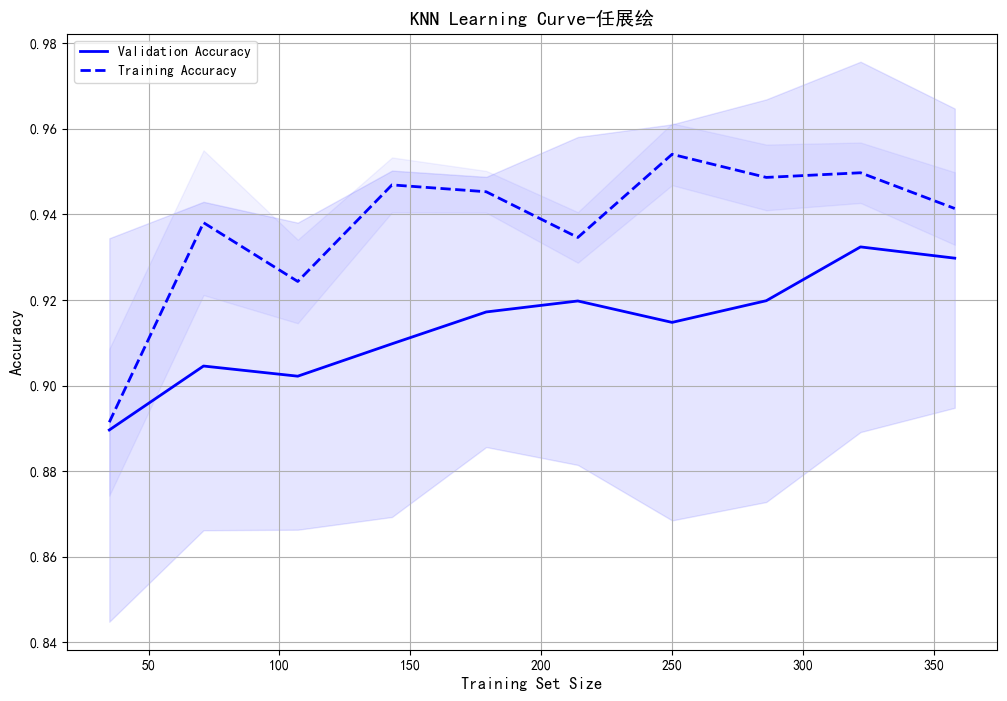

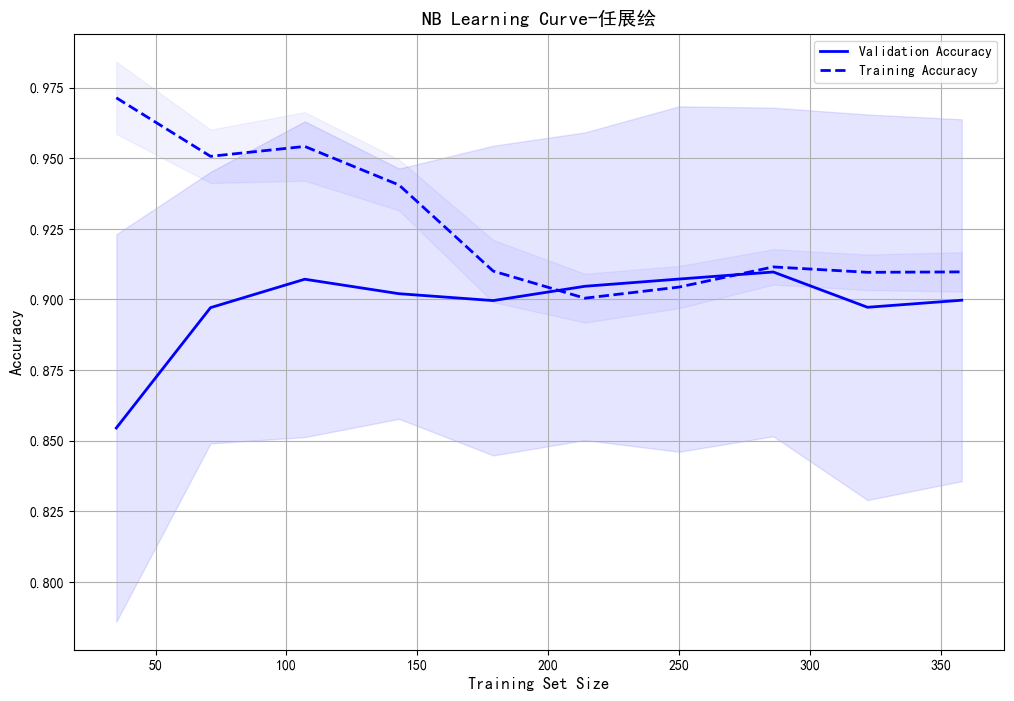

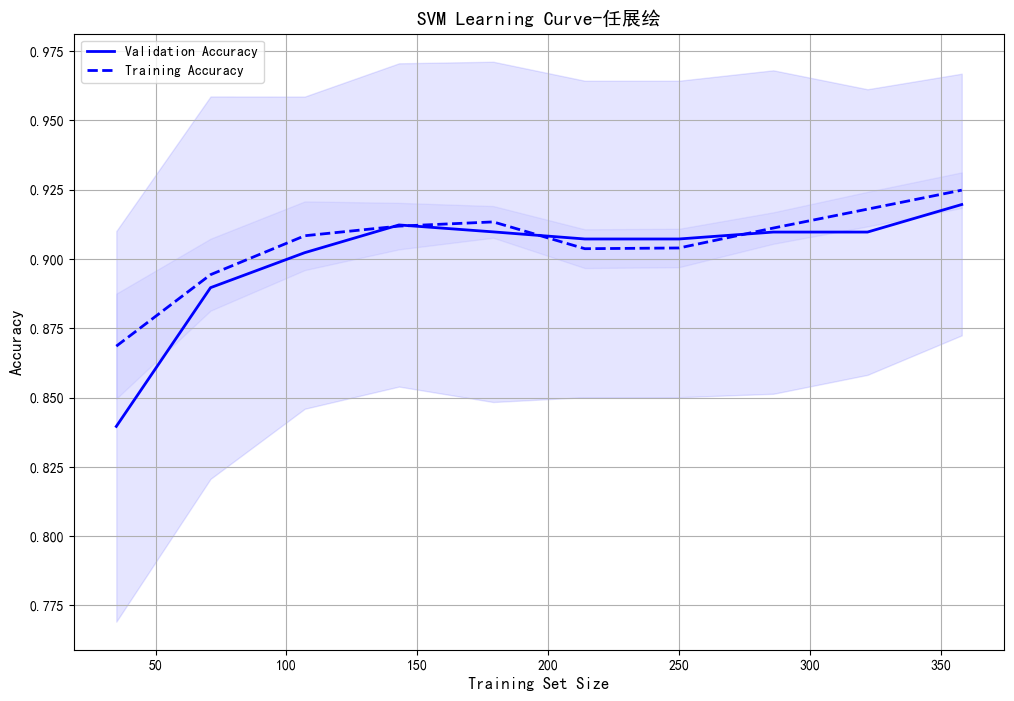

In [55]:

# 学习曲线（KNN、NB、SVM）
for name, model in best_models.items():
    plt.figure(figsize=(12, 8))
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_train, y_train, cv=kfold, scoring='accuracy', n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 10)
    )
    train_mean = train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    val_mean = val_scores.mean(axis=1)
    val_std = val_scores.std(axis=1)
    
    plt.plot(train_sizes, val_mean, label=f'Validation Accuracy', color='blue', lw=2)
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='blue', alpha=0.1)
    plt.plot(train_sizes, train_mean, label=f'Training Accuracy', color='blue', linestyle='--', lw=2)
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.05)

    plt.xlabel('Training Set Size', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title(f'{name} Learning Curve-任展绘', fontsize=14)
    plt.legend(loc='best')
    plt.grid(True)
    plt.savefig(f'picture/{name}/learning_curve.png')
    plt.show()
    plt.close()

##### We are getting the best accuracy with SVM which is 96.4%  , the model is predicting with 96% accuracy on our test data
